# Weather Impact on Traffic Accidents

## Problem Statement
For this project, I aim to determine if inclement weather causes more frequent and severe accidents compared to clear and sunny weather. Understanding this relationship can inform public safety campaigns, resource allocation for emergency services, and urban planning initiatives aimed at improving road safety during poor weather conditions. 


## Step 1: Gather Data

### Dataset 1:

I will be utilizing the "Motor Vehicle Collisions - Crashes" dataset because it provides comprehensive historical data on motor vehicle accidents in New York City. Its detailed records, including crash dates and locations, are essential for correlating accident occurrences with specific weather conditions. This dataset's breadth allows for an in-depth analysis of both the frequency and severity of collisions across the city.

Dataset Type: CSV

Data Wrangling Method: The data is gathered by programmatically downloading files from the NYC Open Data Portal

Dataset variables that will be used:

 - **CRASH DATE**: Date the collision occured
 - **CRASH TIME**: Time the collision occured
 - **LATITUDE**: Latitude coordinate of the collision
 - **LONGITUDE**: Longitude coordinate of the collision
 - **NUMBER OF PERSONS INJURED**: Amount of total injuries in collision
 - **NUMBER OF PERSONS KILLED**: Amount of total fatalities in collision
 - **COLLISION_ID**: Unique identifier for the collision


In [1]:
# Imports required for workbook
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load in first dataset

# URL for the CSV version of the dataset
csv_url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"

# Defines a filename to save the dataset to
file_name = "motor_vehicle_collisions_subset.csv"

try:
    # Use pandas to read a limited number of rows directly from the URL.
    # The `nrows` parameter is key to grabbing only a small chunk of the data,
    # avoiding the large file size issue.
    print(f"Reading the first 100,000 records from {csv_url}...")
    motor_accident_df = pd.read_csv(csv_url, nrows=100000)
    
    # Save the smaller DataFrame to a new CSV file
    motor_accident_df.to_csv(file_name, index=False)
    print(f"Successfully created a subset and saved it to {file_name}")

    # Display the number of rows to confirm the result
    print(f"The DataFrame now contains {len(motor_accident_df)} rows.")

except requests.exceptions.RequestException as e:
    print(f"Error accessing the data URL: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Reading the first 100,000 records from https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD...
Successfully created a subset and saved it to motor_vehicle_collisions_subset.csv
The DataFrame now contains 100000 rows.


### Dataset 2:

I will be utilizing the Open-Meteo Historical Weather API dataset for its comprehensive and freely accessible historical weather data, which is curcial for identifying correlations with past motor vehicle collisions. It contains detailed daily weather variables (like temperature, precipitation, and wind) for specific geographical coordinates and extensive date ranges. This will allow for a robust investigation into how different weather conditions might influence accident frequency and severity in New York City.

Dataset Type: JSON

Data Wrangling Method: The data is gathered by utilizing the Open-Meteo Historical Weather API

Dataset variables that will be used:

*    **time:** Date the weather data was recorded
*    **temperature_2m_max:** Maximum daily air temperature 2 meters above ground
*    **temperature_2m_min:** Minimum daily air temperature 2 meters above ground
*    **precipitation_sum:** Total daily sum of precipitation
*    **rain_sum:** Total daily sum of rain only
*    **snowfall_sum:** Total daily sum of snow only
*    **precipitation_hours:** Number of hours with any type of precipitation on that day
*    **weather_code:** Numerical code that summarizes the overall daily weather condition
*    **wind_speed_10m_max:** Maximum daily wind speed 10 meters above ground
*    **wind_gusts_10m_max:** Maximum daily wind gust (sudden, brief increase in wind speed) at 10 meters above ground
*    **wind_direction_10m_dominant:** Dominant daily wind direction 10 meters above ground


> The first thing I do is create a function called **get_open_meteo_historical_weather** that takes in latitude, longitude, start_date, end_date, and daily_variables which is set to **None** initially to make the parameter optional and allow the function to define a fresh default list of variables if the caller doesnt provide the function a list of desired daily_variables

In [4]:
def get_open_meteo_historical_weather(latitude, longitude, start_date, end_date, daily_variables=None):

    base_url = "https://archive-api.open-meteo.com/v1/archive"

    # If no daily_variable is provided by caller, the function sets this to grab useful weather data
    if daily_variables is None:
        daily_variables = [
            "temperature_2m_max",
            "temperature_2m_min",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "weather_code",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant"
        ]

    # Sets parameters to be used using the information entered into function
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ",".join(daily_variables),
        "timezone": "America/New_York" # Set timezone for accurate day boundaries
    }   

    print(f"Fetching weather data for {start_date} to {end_date} at Lat: {latitude}, Lon: {longitude}")

    try: 

        # Sends a request to the url and stores the information retrieved in response variable
        response = requests.get(base_url, params=params)

        # Raises an HTTPError for bad responses (4XX or 5XX Codes)
        response.raise_for_status()
        data = response.json()

        # Checks to see if the API response contains the key 'daily'
        if "daily" in data:

            # Extracts value associated with the 'daily' key
            daily_data = data['daily']

            # Converts daily_data dictionary inro a Pandas DataFrame
            weather_data_df = pd.DataFrame(daily_data)

            return weather_data_df
        
        else:

            # Print response for debugging if the 'daily' ket is not found
            print("No 'daily' data found in the API response. Check parameters or date range")
            print("API Response:", data)
            return None
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from Open-Meteo API: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occured: {e}")
        return None


In [5]:
# Load in dataset 2
# Coordinates for Central Park, NYC (approximate)
nyc_latitude = 40.7831
nyc_longitude = -73.9712

# Sets a desired data range to compare to motor collision dataset
start_date = "2012-07-01"
end_date = "2025-05-28"

# Fetch the data using the created function
nyc_weather_df = get_open_meteo_historical_weather(
    nyc_latitude,
    nyc_longitude,
    start_date,
    end_date
)

# Prints messsage stating if data was retrieved or not and stores file in CSV file once obtained
if nyc_weather_df is not None:
    print("NYC historical weather data has been successfully retrieved")

    # Defines the gile name for weather data CSV
    weather_file_name = "nyc_historical_weather.csv"

    # Converts file to CSV
    nyc_weather_df.to_csv(weather_file_name, index=True)
else:
    print("Failed to retrieve NYC historcal weather data.")


Fetching weather data for 2012-07-01 to 2025-05-28 at Lat: 40.7831, Lon: -73.9712
NYC historical weather data has been successfully retrieved


## Step 2: Assess Data

> I first perform basic data inspection using the .info() and .head() funcitons to get an idea of what the data looks like in my datasets.

In [3]:
motor_accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     100000 non-null  object 
 1   CRASH TIME                     100000 non-null  object 
 2   BOROUGH                        65611 non-null   object 
 3   ZIP CODE                       65600 non-null   float64
 4   LATITUDE                       92061 non-null   float64
 5   LONGITUDE                      92061 non-null   float64
 6   LOCATION                       92061 non-null   object 
 7   ON STREET NAME                 72876 non-null   object 
 8   CROSS STREET NAME              46361 non-null   object 
 9   OFF STREET NAME                27123 non-null   object 
 10  NUMBER OF PERSONS INJURED      100000 non-null  int64  
 11  NUMBER OF PERSONS KILLED       100000 non-null  int64  
 12  NUMBER OF PEDESTRIANS INJURED  

In [9]:
motor_accident_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [6]:
nyc_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4715 entries, 0 to 4714
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   time                         4715 non-null   object 
 1   temperature_2m_max           4715 non-null   float64
 2   temperature_2m_min           4715 non-null   float64
 3   precipitation_sum            4715 non-null   float64
 4   rain_sum                     4715 non-null   float64
 5   snowfall_sum                 4715 non-null   float64
 6   precipitation_hours          4715 non-null   float64
 7   weather_code                 4715 non-null   int64  
 8   wind_speed_10m_max           4715 non-null   float64
 9   wind_gusts_10m_max           4715 non-null   float64
 10  wind_direction_10m_dominant  4715 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 405.3+ KB


In [10]:
nyc_weather_df.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2012-07-01,34.8,20.1,1.7,1.7,0.0,1.0,61,17.0,37.1,268
1,2012-07-02,31.0,19.7,0.0,0.0,0.0,0.0,2,14.0,26.3,321
2,2012-07-03,31.9,18.6,0.0,0.0,0.0,0.0,3,12.1,25.6,269
3,2012-07-04,33.7,20.5,3.9,3.9,0.0,4.0,61,10.9,26.3,251
4,2012-07-05,34.9,24.3,0.0,0.0,0.0,0.0,3,14.4,24.1,321


### Quality Issue 1: Mixed Data Types In Motor Accident DataFrame 

The first quality issue that I noticed is that there are some mislabled data types that are in the motor_accident_df. The CRASH DATE and CRASH TYPE are of type object when they should have been assigned as type datetime. Another issue is that both NUMBER OF PERSONS INJURED and NUMBER OF PERSONS KILLED are both assigned as type float when they should have been assigned as type int since it is impossible in injur or kill half of a person for example. 

In [7]:
# Inspecting Motor Accidents DataFrame Programmatically
# Function that sees if there are multiple types in a specific column
def check_mixed_types(series):

    # Filter out all the nulls to type check what is stored
    non_nan_values = series.dropna()

    # Gets the type of each non_NaN value
    unique_types = set(non_nan_values.apply(type))

    return len(unique_types) > 1, unique_types

In [8]:
# List of columns to check data types on
column_names = ['CRASH DATE', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']

#Loop created to run the function on all columns in the above list
for i in column_names:

    # Runs the function using the columns specified in column_names
    is_mixed, types_found = check_mixed_types(motor_accident_df[i])

    # Prints if the column contains mixed type or not
    if is_mixed:
        print(f"Column '{i}': Has Mixed Data Types. Types Found: {types_found}")
    else:
        print(f"Column '{i}': Does Not Have Mixed Data Types. Type Found: {types_found}")

Column 'CRASH DATE': Does Not Have Mixed Data Types. Type Found: {<class 'str'>}
Column 'NUMBER OF PERSONS INJURED': Does Not Have Mixed Data Types. Type Found: {<class 'int'>}
Column 'NUMBER OF PERSONS KILLED': Does Not Have Mixed Data Types. Type Found: {<class 'int'>}


> Based on the function that was run above, we are able to see that the columns that are going to be used for analysis do not have the issue of having multiple types assigned to the row. This shows that all the datatypes in each column are consistent. Knowing this, I can now safely address the fact that they are stored as the wrong type during the cleaning of my datasets.


### Quality Issue 2: Missing Values in Motor Accident DataFrame

The next quality issue that needs to be addressed is the problem of NaN values in various columns in the Motor Accident DataFrame. Many of these columns will not be needed for analysis, so I will first be addressing what columns are going to be needed, inspect the amount of null values in said columns, and decide if there is enough filled in information to be able to gain insights using the column. If the column will not be used for analysis, it will be dropped when performing cleaning

> The first thing I will do is create a heatmap of the null values in the dataset. This will provide me with a visual of what data is filled in in the dataset.

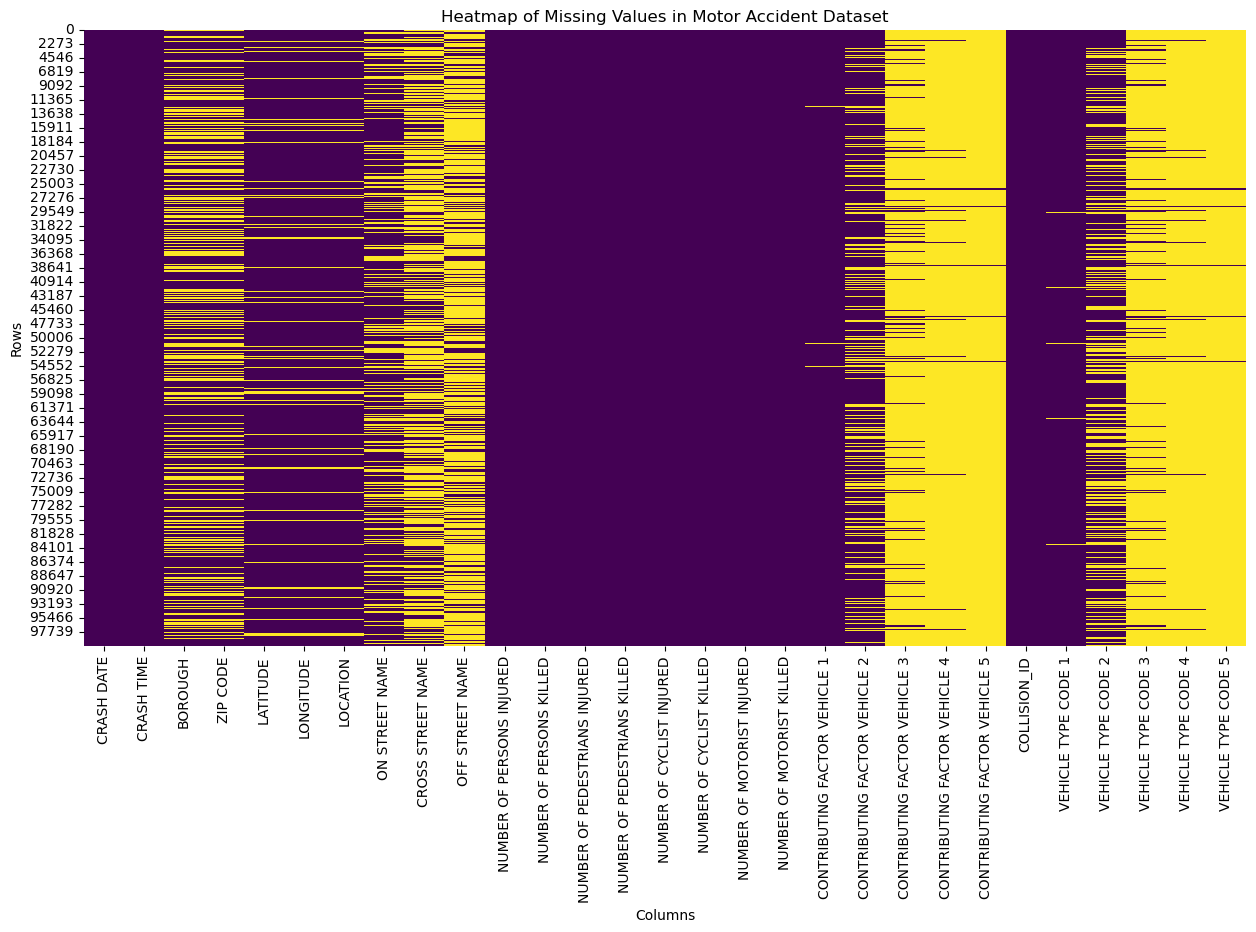

In [12]:
# Visualizing null values in dataset
# Creating a boolean dataframe that indicates missing values
missing_df = motor_accident_df.isnull()

# Creates a heatmap using the missing_df created
plt.figure(figsize=(15, 8))
sns.heatmap(missing_df, cbar=False, cmap="viridis") # 'viridis' shows missing in different color
plt.title("Heatmap of Missing Values in Motor Accident Dataset")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

Looking at the heatmap created above, we are able to determine that there are some unusable rows due to the sheer amount of missing values in their fields. Luckily, the columns that I plan on using for analysis seem to have enough information filled in to be utilized for creating visuals and performing analysis. Seeing that none of the columns with missing values that deal with locations can be imputed, it would be wise to drop any entries that have null values in those entries if they are going to be required for analysis, such as latitude and longitude of the accident.

In [14]:
motor_accident_df.isnull().sum()

CRASH DATE                           0
CRASH TIME                           0
BOROUGH                          34389
ZIP CODE                         34400
LATITUDE                          7939
LONGITUDE                         7939
LOCATION                          7939
ON STREET NAME                   27124
CROSS STREET NAME                53639
OFF STREET NAME                  72877
NUMBER OF PERSONS INJURED            0
NUMBER OF PERSONS KILLED             0
NUMBER OF PEDESTRIANS INJURED        0
NUMBER OF PEDESTRIANS KILLED         0
NUMBER OF CYCLIST INJURED            0
NUMBER OF CYCLIST KILLED             0
NUMBER OF MOTORIST INJURED           0
NUMBER OF MOTORIST KILLED            0
CONTRIBUTING FACTOR VEHICLE 1      503
CONTRIBUTING FACTOR VEHICLE 2    22599
CONTRIBUTING FACTOR VEHICLE 3    89698
CONTRIBUTING FACTOR VEHICLE 4    97220
CONTRIBUTING FACTOR VEHICLE 5    99153
COLLISION_ID                         0
VEHICLE TYPE CODE 1               1195
VEHICLE TYPE CODE 2      

### Tidiness Issue 1: Crash Date and Time Separation

The first tidiness issue that I noticed that will need to be addressed is the fact that the CRASH DATE and CRASH TIME columns have been separated into two seperate object columns rather than being stored into a single datatime type. This will be addressed, as there are many usefule datetime functions that can be utilized

In [17]:
# Visually showing the CRASH DATE and CRASH TIME are seperate columns rather than one
motor_accident_df[['CRASH DATE', 'CRASH TIME']].head()

,CRASH DATE,CRASH TIME
0,09/11/2021,2:39
1,03/26/2022,11:45
2,11/01/2023,1:29
3,06/29/2022,6:55
4,09/21/2022,13:21


### Tidiness Issue 2: Unneeded LOCATION Column

The next tidiness issue that will be addressed is that fact that there is a column for latitude, longitude, and location. The location column is just the latitude and longitude values stored together in an object, sot it will not be as usable as the latitude and longitude columns which are stored as float types

In [18]:
# Inspecting the dataframe visually
print(motor_accident_df[['LATITUDE', 'LONGITUDE', 'LOCATION']].sample(5))

        LATITUDE  LONGITUDE                 LOCATION
60050  40.666565 -73.988495  (40.666565, -73.988495)
15773  40.725430 -73.996780    (40.72543, -73.99678)
81882  40.593190 -74.082405   (40.59319, -74.082405)
7170   40.817380 -73.925700     (40.81738, -73.9257)
17561  40.841133 -73.924000     (40.841133, -73.924)


In [19]:
print(motor_accident_df['LOCATION'].dtype)

object


> As shown above, we can see that the LOCATION column of the dataset is just the LATITUDE and LONGITUDE columsn brought together and stored as an object